In [19]:
from math import pi, sqrt
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#[Lauffer 1944]: diameter 109 +/- 16.65 nm
#[Ruigrok 1984]: diameter 115 +/- 12 nm

#57.5 avg to 63.5 nm 

sigma_diameter = (16.65+12)/2.0

#[Ruigrok 1984]: mass 160 MDa +/- 17 MDa
sigma_mass = (17.0+24.0)/2.0

sigma_breaking_strength = (17.0+24.0)/2.0


In [6]:
avg_dia = 57.5 
one_sigma_pos_dia = avg_dia + sigma_diameter
volume_sigma = (((4/3.0) * pi * (one_sigma_pos_dia)**2.0)/((4/3.0) * pi * (avg_dia)**2.0))-1.0
volume_sigma
avg_mass = 75
one_sigma_mass = avg_mass*volume_sigma
one_sigma_mass


42.02451323251418

In [4]:
#Extracted from [Li 2011] using https://apps.automeris.io/wpd/,

count = [2.9816513761467904,
6.0091743119266035,
15.045871559633028,
21.14678899082569,
17.93577981651376,
11.10091743119266,
11.972477064220184,
11.972477064220184,
15.458715596330272,
8.119266055045873,
19.174311926605505,
9.908256880733944,
6.834862385321103,
5.045871559633027,
7.018348623853214,
2.018348623853214,
1.0091743119266046]


breaking_force = [0.24179620034542312,
0.33851468048359246,
0.4421416234887737,
0.5423143350604491,
0.6528497409326425,
0.753022452504318,
0.8186528497409327,
0.9395509499136444,
1.0466321243523315,
1.143350604490501,
1.2469775474956826,
1.3506044905008636,
1.4300518134715028,
1.5474956822107082,
1.6165803108808294,
1.7305699481865287,
1.9412780656303976]

In [11]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

popt, _ = curve_fit(gaussian, breaking_force, count)
mean_breaking_force = popt[0]
sigma_breaking_force = popt[2]

mean_breaking_force



0.8407145507834908

We very simply extend [Yang 2015]'s analysis to include the distribution of viral particles. We continue using H3N1 rather than the target SARS-NCoV-2 because of an apparent lack of AFM data.

    The majority of virions (n = 78) may be described as spherical (axial ratio 1.2), the remainder are oval or   kidney-shaped with axial ratios up to 1.4 (n = 17) or more elongated with axial ratios as high as 7.7 (n = 15). The outer diameters of the spherical virions ranged from 84 to 170 nm (mean, 120 nm).

Note that, per [Lauffer 1944], of Inf A and B, "the infectious particles have diameters within the range 80 to 135[nm]".

[Yang 2015]'s MDCK plaque assay is already sensitive to infectivity; the extreme-sized non-infective mutants would already be filtered out. Their PCR assay might not be; the DNA of all non-infectious mutants would be considered.

[Yang 2015] use a minimum force of 400 pN, citing [Li 2011]:

> More than 95% puncture events occurred above 0.4 nN.

This probably accounts for the high 100% threshold.

The mass, diameter, and breaking force are presumably not independently distributed. The correlations between the three variables do not seem to be documented in the literature.

There seems to be little variation in the mass of the spike proteins; intact H3N1 is 161 MDa +/- 17, with spikes removed, 75 MDa +/- 17.  [Ruigrok 1984]  

The average stiffness of the liposome varies approximately linearly from 0.025 to 0.015 from 80 to 135 nm [Li 2011], plus a random distribution with approx. 0.0025 sigma. 

Size and weight are assumed to be uncorrelated with breaking strength.


From [Yang 2015], eq. 7,

$ A = \frac{q E_0}{\mu \sqrt{((2 \pi f_{res})^2 - (2 \pi f_{excite})^2)^2 + \left(\frac{(2 \pi f_{res})(2 \pi f_{excite})}{Q}\right)^2}} $


The resonant frequency varies as $\sqrt{k/m^*}$.



In [35]:
#Max sneeze particle velocity is 6 m/s. [Nishimura 2013]

#the particle can travel 0.005 m per pulse.

max_velocity = 6.0 
max_allowable_distance = 0.005 #m
max_interval = max_allowable_distance/max_velocity

repetition_freq = 1.0/max_interval


pulse_duration = 1e-6 #seconds


duty_cycle = repetition_freq * pulse_duration 

pulse_power_draw = 2.0*80e-3 # volts * amps - not equivalent to the RF output power, do note

average_power = duty_cycle * pulse_power #watts

#battery_capacity = 0.1575 #watt-hours - a single LR44 zinc cell
battery_capacity = 1.725

battery_life_months = (battery_capacity / average_power) / 24 / 30 # months


0.00019199999999999998

In [81]:
pulse_RF_output_power_watts = 0.125 # watts

exposure_area = (0.01**2.0) #m

exposure_flux_w_m2 = pulse_RF_output_power_watts / exposure_area
exposure_flux_w_m2

1250.0

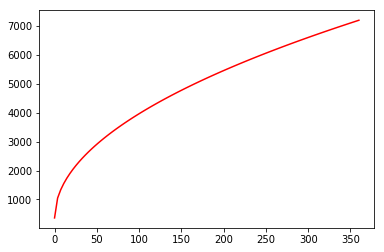

In [79]:
#ICNIRP 2020, Table 3, General Public.
#HEALTH PHYS118(5): 483–524; 2020
#PUBLISHED AHEAD OF PRINT IN MARCH 2020: HEALTH PHYS 118(00):000–000; 2020
# t is time in seconds, and restrictions must be satisfied for all values of t between >0 and <360 s, 
# regardless of the temporal characteristics of the exposure itself.
# Local Uab is to be averaged over a square 4-cm^2 surface area of the body.
# Exposure from any pulse, group of pulses, or subgroup of pulses in a train, as well as from 
# the summation of exposures (including non-pulsed
# EMFs), delivered in t s, must not exceed these levels.
#
# The SA and U ab values are conservative in that they are
# not sufficient to raise Type 1 or Type 2 tissue temperatures
# by 5 or 2°C, respectively.

#there's also Table 7, giving the equation 
#55/f G 0.177

#Converted from kJ/m^2
def specific_energy_j_m2(t):
    return 7.2*(0.05+0.95*((t/360.0)**0.5))*1000.0 # J/m^2

#t = 0

t = np.linspace(0,360,100)

plt.plot(t,specific_energy_j_m2(t), 'r')



ValueError: x and y must have same first dimension, but have shapes (11999,) and (11998,)

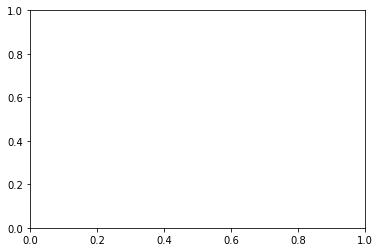

In [104]:
pulse_t = np.linspace(0,1,int(repetition_freq*10))

guideline_energy_integral_J_m2 = 0
guideline_energy = []

pulse_energy_integral_J_m2 = 0
pulse_energy = []

for idx,t_ in enumerate(pulse_t[0:-1]):
    dt = (pulse_t[idx+1]-t_)
    
    pulse_energy_integral_J_m2 += pulse_RF_output_power_watts * dt / exposure_area

    
    guideline_energy_integral_J_m2 = (specific_energy_j_m2(t_))       
    guideline_energy.append(guideline_energy_integral_J_m2)
    pulse_energy.append(pulse_energy_integral_J_m2)

#wait, we could have just symbolically integrated this. oh well. 
#I guess this is more flexible in terms of step response? Nah, just being dumb.
#no, wait, isn't that equation already an integral over energy?

plt.plot(pulse_t[0:-1], guideline_energy[0:-1], 'r')
plt.plot(pulse_t[0:-1], pulse_energy[0:-1], 'g')

pulse_energy_integral * repetition_freq